In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer, RobertaForSequenceClassification
from transformers import AdamW
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
from collections import OrderedDict
from scipy.spatial.distance import cosine
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', 'simcse')))
from sim_utils import load_examples, Inputexample, CustomTextDataset, freeze_layers, test
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoConfig, AutoModel, AutoTokenizer
from loss import Similarity, create_supervised_pair, supervised_contrasive_loss

 
#comment this if you are not using puffer
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

### Train With Combine loss between Cross Entropy and SuperVised Contrastive loss 

### Test function

## Define Parameters

### The Aim of these training is to fine tuning on few shot setting on text classification task

Path example of train, validation and test 

In [2]:
N = 5
data = []
labels = []

train_samples = []
train_labels = []

valid_samples = []
valid_labels = []

test_samples = []
test_labels = []

embed_dim = 768
batch_size = 16 
lr=2e-3  # you can adjust 
temp = 0.3  # you can adjust 
lamda = 0.01  # you can adjust  
skip_time = 0 # the number of time that yi not equal to yj in supervised contrastive loss equation 
data_name = 'BANKING77'
model_name = 'simcse_sup'
shot_name = 'train_5'
exp_name = f'{model_name}_lr={lr}_t={temp}_{data_name}_{shot_name}'
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [3]:
path_shot = f'../../../../Thesis/{data_name}/{shot_name}/'
valid_path = f'../../../../Thesis/{data_name}/valid/'
test_path = f'../../../../Thesis/{data_name}/test/'
print("train path : ",path_shot)
print("valid path : ",valid_path)
print("test path  : ",test_path)
print("experiment code name :",exp_name)

train path :  ../../../../Thesis/BANKING77/train_5/
valid path :  ../../../../Thesis/BANKING77/valid/
test path  :  ../../../../Thesis/BANKING77/test/
experiment code name : simcse_sup_lr=0.002_t=0.3_BANKING77_train_5


In [4]:
# Download data fewshot 
# https://downgit.github.io/#/home?url=https:%2F%2Fgithub.com%2Fjianguoz%2FFew-Shot-Intent-Detection%2Ftree%2Fmain%2FDatasets%2FHWU64

# load data
train_samples = load_examples(path_shot)
valid_samples = load_examples(valid_path)
test_samples = load_examples(test_path)


print("===== small train set ====")

for i in range(len(train_samples)):
    data.append(train_samples[i].text)
    labels.append(train_samples[i].label)


train_data = CustomTextDataset(labels,data,batch_size=batch_size,repeated_label=True)
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)



print("===== validation set ====")

data = []
labels = []

for i in range(len(valid_samples)):
    data.append(valid_samples[i].text)
    labels.append(valid_samples[i].label)

valid_data = CustomTextDataset(labels,data,batch_size=batch_size,repeated_label=True)
valid_loader = DataLoader(valid_data,batch_size=batch_size,shuffle=True)


print("===== test set ====")

data = []
labels = []
    
for i in range(len(test_samples)):
    data.append(test_samples[i].text)
    labels.append(test_samples[i].label)

test_data = CustomTextDataset(labels,data,batch_size=batch_size,repeated_label=True)
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=True)



# got the number of unique classes from dataset
num_class = len(np.unique(np.array(labels)))

# get text label of uniqure classes
unique_label = np.unique(np.array(labels))

# map text label to index classes
label_maps = {unique_label[i]: i for i in range(len(unique_label))}

===== small train set ====
Train on Combine between Supervised Contrastive and Cross Entropy loss
len of dataset : 385
===== validation set ====
Train on Combine between Supervised Contrastive and Cross Entropy loss
len of dataset : 1540
===== test set ====
Train on Combine between Supervised Contrastive and Cross Entropy loss
len of dataset : 3080


In [5]:
tokenizer = AutoTokenizer.from_pretrained("princeton-nlp/sup-simcse-bert-base-uncased")
config = AutoConfig.from_pretrained("princeton-nlp/sup-simcse-bert-base-uncased")
config.num_labels = num_class

In [6]:
simcse = AutoModelForSequenceClassification.from_pretrained("princeton-nlp/sup-simcse-bert-base-uncased",config=config)
simcse = freeze_layers(simcse,freeze_layers_count=12)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at princeton-nlp/sup-simcse-bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


classifier.weight
classifier.bias


In [7]:
optimizer= AdamW(simcse.parameters(), lr=lr)
simcse = simcse.to(device)

In [17]:
def train_contrastive_learnig(model,optimizer,loss_fct,label_maps,temp,train_loader,tokenizer,valid_loader,train_data,valid_data,device,lamda,epochs:int=30):
    
    
    train_loss_hist = [] 
    valid_loss_hist = []
    
    train_acc_hist = []
    valid_acc_hist = []
    

    test_acc = []

    min_valid_loss = np.inf
    skip_train = 0 # the number of time that yi not equal to yj in supervised contrastive loss equation
    skip_valid = 0 
    for e in range(epochs):  # loop over the dataset multiple times
 
        model.train()
        correct = 0
        running_loss = 0.0
       

        for (idx, batch) in enumerate(train_loader):
            sentence = batch["Text"]
            inputs = tokenizer(sentence,padding=True,truncation=True,return_tensors="pt")
            
          
     
            
            if len(np.unique(batch["Class"])) == len(batch["Class"]):
                skip_train +=1 
                print("skip_train:",skip_train)
                
                continue
            
            # move parameter to device
            # inputs decompose into  input_ids, token_type_ids, attention_mask

            inputs = {k:v.to(device) for k,v in inputs.items()}

            # map string labels to class idex
            labels = [label_maps[stringtoId] for stringtoId in (batch['Class'])]

            # convert list to tensor
            labels = torch.tensor(labels).unsqueeze(0)
            labels = labels.to(device)


             # clear gradients
            optimizer.zero_grad()

            outputs = model(**inputs,labels=labels,output_hidden_states=True)     
        
            hidden_states = outputs.hidden_states

            last_hidden_states = hidden_states[12]

            # https://stackoverflow.com/questions/63040954/how-to-extract-and-use-bert-encodings-of-sentences-for-text-similarity-among-sen 
            # (batch_size,seq_len,embed_dim)
            h = last_hidden_states[:,0,:]

            
            # create pair samples
            T, h_i, h_j, idx_yij = create_supervised_pair(h,batch['Class'],debug=False)

             
            # if h_i is None:
            #     print("train : h_i is skipped:")
            #     print("labels :",batch['Class'])
            #     print("unique labels :",len(np.unique(batch['Class'])))
            #     print("full labels :",len(batch['Class']))
            #     continue

            # supervised contrastive loss 
            
            loss_s_cl = supervised_contrasive_loss(device,loss_fct,h_i, h_j, h, T,temp=temp,idx_yij=idx_yij,debug=False)

            # cross entropy loss
            loss_classify, logits = outputs[:2]

            # loss total
            loss = loss_s_cl + (lamda * loss_classify )

            # Calculate gradients
            loss.backward()

            # Update Weights
            optimizer.step()

            # Calculate Loss
            running_loss += loss.item()
            
            #calculate nums of correction 
            correct += (torch.max(logits,dim=-1)[1] == labels).sum()

        
        train_loss_hist.append(running_loss/len(train_data))
        train_acc_hist.append(correct/len(train_data))
        
        
        print(f'======  Epoch {e+1} ====== ')
        print(f' Training Loss: {running_loss/len(train_data)}, \t\t Training acc: {correct/len(train_data)}')
        
        print("train correct : ",correct)
        print("train total :",len(train_data))
        
        
        running_loss = 0.0
        correct = 0
        model.eval()     # Optional when not using Model Specific layer
        log_correct = []
        
        
        for (idx, batch) in enumerate(valid_loader):
            
            sentence = batch["Text"]
            inputs = tokenizer(sentence,padding=True,truncation=True,return_tensors="pt")
            
            
              
            if len(np.unique(batch["Class"])) == len(batch["Class"]):
                skip_valid +=1 
                print("skip_valid",skip_valid)
                continue

            
            #assert len(np.unique(batch["Class"])) < len(batch["Class"])  
            # move parameter to device
            inputs = {k:v.to(device) for k,v in inputs.items()}

            # map string labels to class idex
            labels = [label_maps[stringtoId] for stringtoId in (batch['Class'])]

            # convert list to tensor
            labels = torch.tensor(labels).unsqueeze(0)
            labels = labels.to(device)


             # clear gradients
            optimizer.zero_grad()
            
            
            outputs = model(**inputs,labels=labels,output_hidden_states=True)     
        
            hidden_states = outputs.hidden_states

            last_hidden_states = hidden_states[12]

            # https://stackoverflow.com/questions/63040954/how-to-extract-and-use-bert-encodings-of-sentences-for-text-similarity-among-sen 
            # (batch_size,seq_len,embed_dim)
            h = last_hidden_states[:,0,:]

            # create pair samples
            T, h_i, h_j, idx_yij = create_supervised_pair(h,batch['Class'],debug=False)

#             if h_i is None:
#                 print("valid : h_i is skipped:")
#                 print("labels :",batch['Class'])
#                 print("unique labels :",len(np.unique(batch['Class'])))
#                 print("full labels :",len(batch['Class']))
#                 continue
          
            # supervised contrastive loss 
            loss_s_cl = supervised_contrasive_loss(device,loss_fct,h_i, h_j, h, T,temp=temp,idx_yij=idx_yij,debug=False)

            # cross entropy loss
            loss_classify, logits = outputs[:2]

            # loss total
            loss = loss_s_cl + (lamda * loss_classify )
            
            # Calculate Loss
            running_loss += loss.item()
            
            #calculate nums of correction 
            correct += (torch.max(logits,dim=-1)[1] == labels).sum()
            
        # add code to logging
        valid_loss_hist.append(running_loss/len(valid_data))
        valid_acc_hist.append(correct/len(valid_data))
        
        print(f' Validation Loss: {running_loss/len(valid_data)}, \t\t Validation acc: {correct/len(valid_data)}')
        
        print("valid correct : ",correct)
        print("valid total :",len(valid_data))
       
        
        
        # save best current model 
        if min_valid_loss > (running_loss/len(valid_data)):
            print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{running_loss/len(valid_data):.6f}) \t Saving The Model')
            min_valid_loss = running_loss/len(valid_data) 
            torch.save(model.state_dict(), 'saved_model.pth')
            
       
            
    return (train_acc_hist, train_loss_hist), (valid_acc_hist, valid_loss_hist)

In [19]:
train_log, valid_log = train_contrastive_learnig(simcse,optimizer,nn.CrossEntropyLoss(),label_maps,temp,train_loader,tokenizer,valid_loader,train_data,valid_data,device,lamda=lamda,epochs=30)

skip_train: 1
======  Epoch 1 ====== 
 Training Loss: 0.07396520763248592, 		 Training acc: 0.9948051571846008
train correct :  tensor(383, device='cuda:1')
train total : 385
skip_valid 1
 Validation Loss: 0.07854061784682335, 		 Validation acc: 0.1389610320329666
valid correct :  tensor(214, device='cuda:1')
valid total : 1540
Validation Loss Decreased(inf--->0.078541) 	 Saving The Model
skip_train: 2
======  Epoch 2 ====== 
 Training Loss: 0.07359591954714292, 		 Training acc: 0.997402548789978
train correct :  tensor(384, device='cuda:1')
train total : 385
skip_valid 2
 Validation Loss: 0.07856871207039078, 		 Validation acc: 0.13311688601970673
valid correct :  tensor(205, device='cuda:1')
valid total : 1540
skip_train: 3
======  Epoch 3 ====== 
 Training Loss: 0.07372118312043029, 		 Training acc: 0.997402548789978
train correct :  tensor(384, device='cuda:1')
train total : 385
 Validation Loss: 0.07950021396209667, 		 Validation acc: 0.1389610320329666
valid correct :  tensor(214

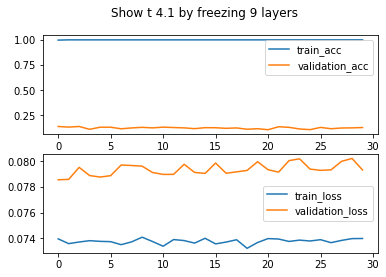

In [20]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Show t 4.1 by freezing 9 layers')
ax1.plot(torch.tensor(train_log[0] , device = 'cpu').tolist())
ax1.plot(torch.tensor(valid_log[0] , device = 'cpu').tolist())
ax1.legend(['train_acc','validation_acc'])
ax2.plot(torch.tensor(train_log[1] , device = 'cpu').tolist())
ax2.plot(torch.tensor(valid_log[1] , device = 'cpu').tolist())
ax2.legend(['train_loss','validation_loss'])

In [21]:
test_acc = test(simcse,device,label_maps,test_loader,len(test_data),tokenizer)

correct : 306
total : 3080


In [22]:
print(f'Accuracy : {100 * test_acc} %') 

Accuracy : 9.935064935064936 %
